### Libraries importing

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys

##Import any other packages you may need here
from itertools import chain
import squarify
from skimage import io

## Check versions
print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
Numpy version: 1.22.3
Pandas version: 1.5.2


### Data loading

In [3]:
## Below is some helper code to read data for you.

columns = ['imgindex', 'labels', 'followup', 'id', 'age', 'sex','position', 'width', 'height', 'x','y', 'wrong']

## Load NIH data
df = pd.read_csv('./data/Data_Entry_2017.csv', index_col=0,header=0,names=columns).drop('wrong', axis=1)

df.head()

imgindex                  labels  followup  id  age sex position  \
0  00000001_000.png            Cardiomegaly         0   1   58   M       PA   
1  00000001_001.png  Cardiomegaly|Emphysema         1   1   58   M       PA   
2  00000001_002.png   Cardiomegaly|Effusion         2   1   58   M       PA   
3  00000002_000.png              No Finding         0   2   81   M       PA   
4  00000003_000.png                  Hernia         0   3   81   F       PA   

   width  height      x      y  
0   2682    2749  0.143  0.143  
1   2894    2729  0.143  0.143  
2   2500    2048  0.168  0.168  
3   2500    2048  0.171  0.171  
4   2582    2991  0.143  0.143

### First data insights

#### Data glossary
- 'id': unique patient id
- labels: Disease types (can be concomitant)
- 'followup': the number of follow-up chest x-ray scan. the first scan has 'nr_follow_up'==0, the second ==1, and so on. The time between two scans is not given.
- 'age': patient age in years
- sex: binary: 'm', 'f'
- 'position':
    - PA: Posteroanterior (PA) view: the x-ray source is positioned in the back of the patient, xray goes from posterior to anterior. 
    Requires patient to be able to standup and hold breath. Not usually possible for critical patients, or patients with reduced mobility. 
    - AP: Anteroposterior chest view is performed with the x-ray tube anteriorly. Usually done on bed for critically ill patients.
- 'width': original image widht
- 'height': original image height
- 'x': Physical distance in the patient between the centers of two 2D pixels (2 adjacent columns, or horizontal spacing) in mm in x direction, also called column spacing
- 'y': Physical distance in the patient between the center of each pixel (2 adjacent rows, or vertical spacing) in mm in y direction, also called row spacing
- 'labels*': label of all deseases/findings.
    - atelectasis
    - cardiomegaly
    - consolidation
    - edema
    - effusion
    - emphysema
    - fibrosis
    - hernia
    - infiltration
    - mass
    - no_finding
    - nodule
    - pleural_thickening
    - pneumonia
    - pneumothorax

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   imgindex  112120 non-null  object 
 1   labels    112120 non-null  object 
 2   followup  112120 non-null  int64  
 3   id        112120 non-null  int64  
 4   age       112120 non-null  int64  
 5   sex       112120 non-null  object 
 6   position  112120 non-null  object 
 7   width     112120 non-null  int64  
 8   height    112120 non-null  int64  
 9   x         112120 non-null  float64
 10  y         112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
df.describe()

followup             id            age          width  \
count  112120.000000  112120.000000  112120.000000  112120.000000   
mean        8.573751   14346.381743      46.901463    2646.078844   
std        15.406320    8403.876972      16.839923     341.246429   
min         0.000000       1.000000       1.000000    1143.000000   
25%         0.000000    7310.750000      35.000000    2500.000000   
50%         3.000000   13993.000000      49.000000    2518.000000   
75%        10.000000   20673.000000      59.000000    2992.000000   
max       183.000000   30805.000000     414.000000    3827.000000   

              height              x              y  
count  112120.000000  112120.000000  112120.000000  
mean     2486.438842       0.155649       0.155649  
std       401.268227       0.016174       0.016174  
min       966.000000       0.115000       0.115000  
25%      2048.000000       0.143000       0.143000  
50%      2544.000000       0.143000       0.143000  
75%      2991.000000       0.168000       0.168000  
max      4715.000000       0.198800       0.198800

In [103]:
print('Total unique patients: ',df['id'].unique().shape[0])

Total unique patients:  30802


#### Data cleaning
There are 16 patients > 150 years with must be a wrong data input. We will exclude them from data analysis as they are non-significant.

In [ ]:
from itertools import chain
all_labels = np.unique(list(chain(*df['labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

In [9]:
mask_age = df['age'] > 100
print('Number of wrong age: {:.0f}'.format(df.loc[mask_age, 'age'].shape[0]))
mask_age = df['age'] > 100
print(df.loc[mask_age, 'age'].sort_values(ascending=False).head(10))
mask_age = df['age'] < 100
df = df.loc[mask_age, :]

Number of wrong age: 16
46965     414
86264     413
20852     412
85404     412
91369     412
84810     411
101194    155
104590    155
98495     154
95794     153
Name: age, dtype: int64


### Basic exploration of all dataset

### Features by sex and position distribution

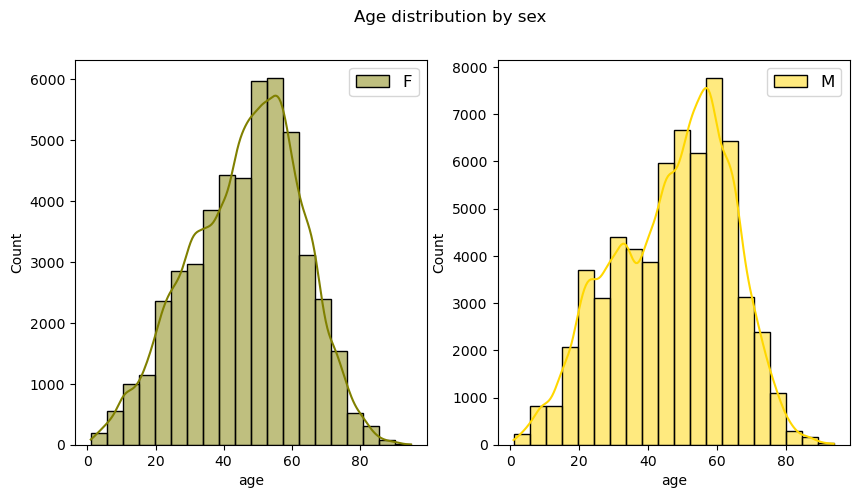

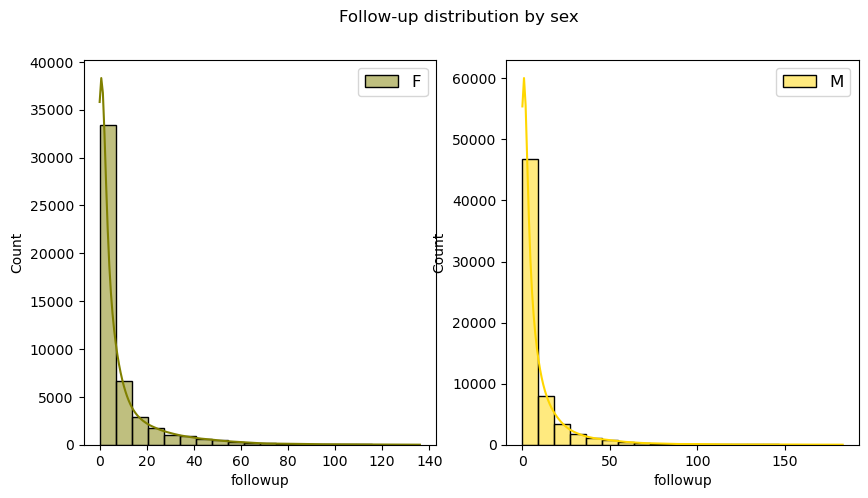

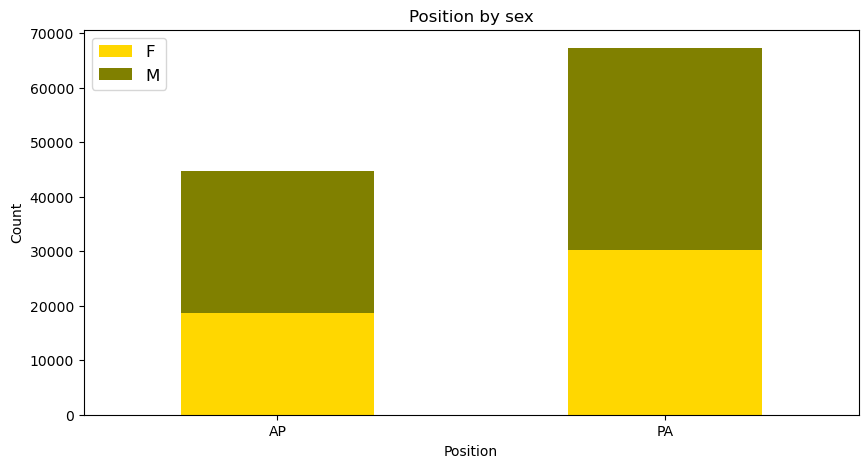

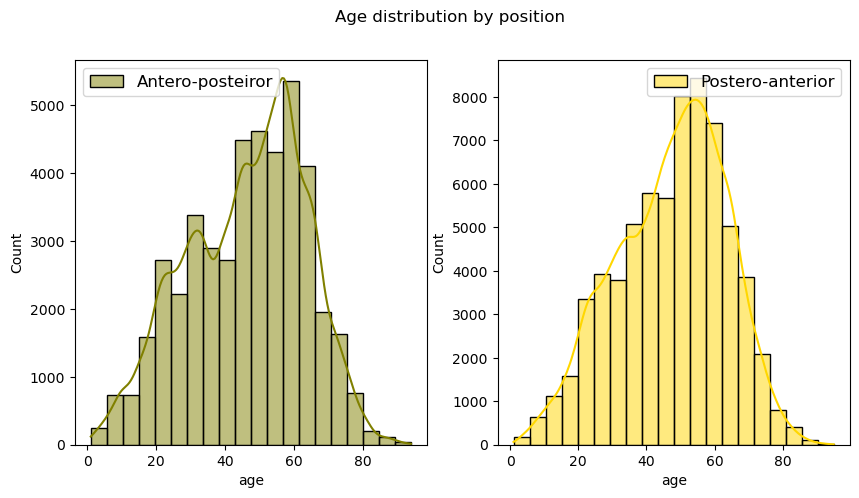

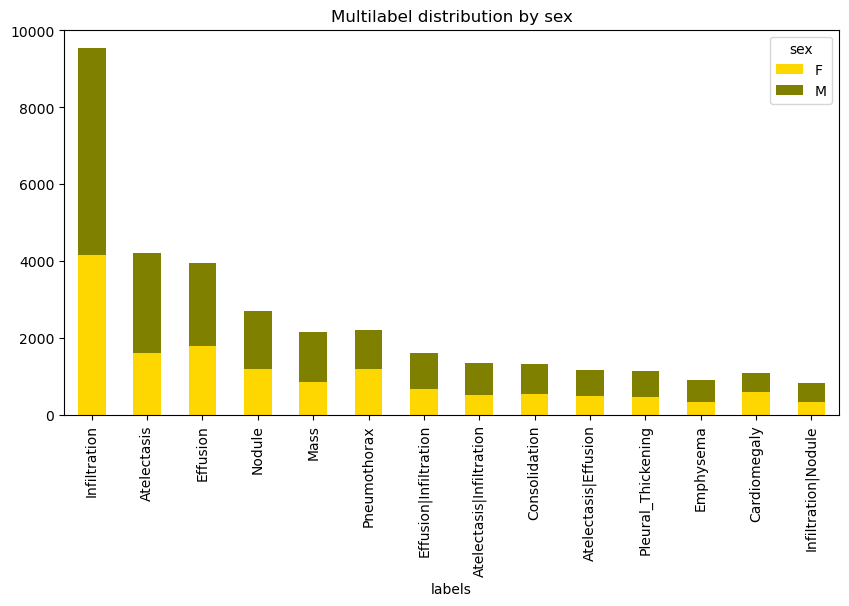

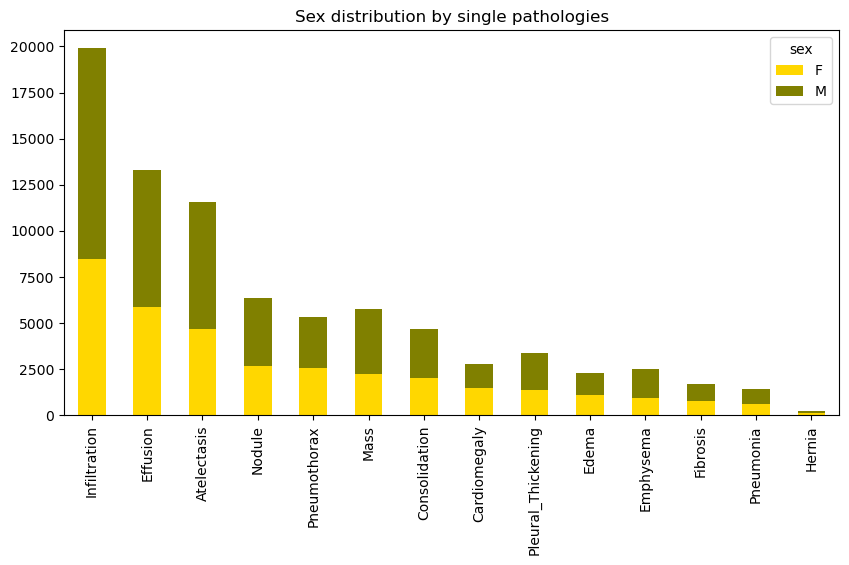

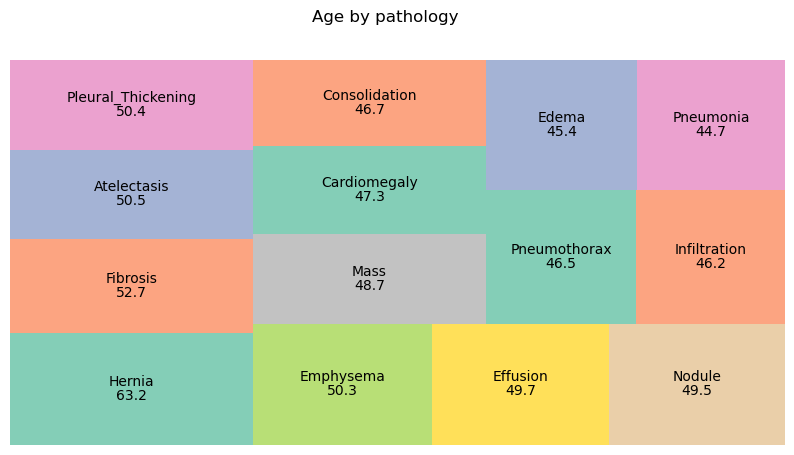

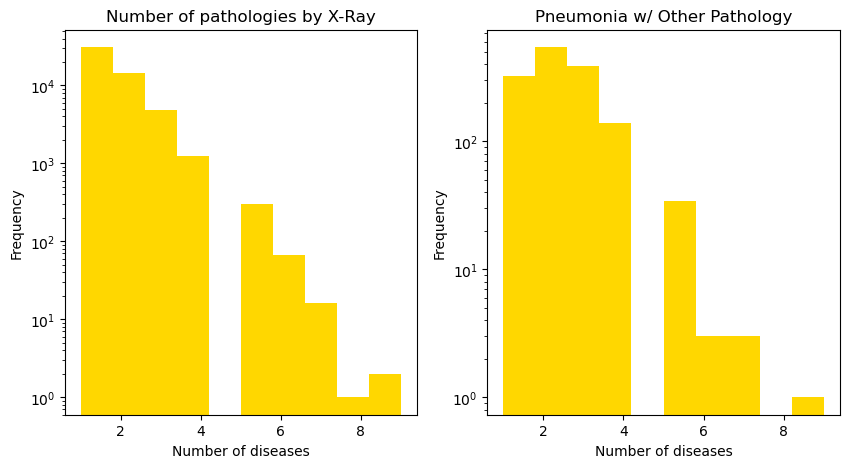

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Age distribution by sex')
sns.histplot(df.loc[df['sex'] == 'F', "age"],
            kde=True, color="olive", label = 'F', bins=20, ax=ax[0])
sns.histplot(df.loc[df['sex'] == 'M', "age"],
            kde=True, color="gold", label = 'M', bins=20, ax=ax[1])
ax[0].legend(prop={'size': 12})
ax[1].legend(prop={'size': 12})
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Follow-up distribution by sex')
sns.histplot(df.loc[df['sex'] == 'F', "followup"],
            kde=True, color="olive", label = 'F', bins=20, ax=ax[0])
sns.histplot(df.loc[df['sex'] == 'M', "followup"],
            kde=True, color="gold", label = 'M', bins=20, ax=ax[1])
ax[0].legend(prop={'size': 12})
ax[1].legend(prop={'size': 12})
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df.groupby('position')['sex'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Position by sex', ax=ax)
ax.legend(prop={'size': 12}, loc='upper left')
plt.xticks(rotation=0)
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Age distribution by position')
sns.histplot(df.loc[df['position'] == 'AP', "age"],
            kde=True, color="olive", label = 'Antero-posteiror', bins=20, ax=ax[0])
sns.histplot(df.loc[df['position'] == 'PA', "age"],
            kde=True, color="gold", label = 'Postero-anterior', bins=20, ax=ax[1])
ax[0].legend(prop={'size': 12})
ax[1].legend(prop={'size': 12})
plt.show()


subset = df[['sex', 'labels']]
subset.index = subset.labels
subset = subset.drop('labels', axis=1)
list_main_labels = subset.groupby(level=0).value_counts().unstack().fillna(0).sort_values(by='M', ascending=False)[1:15]
list_main_labels.plot(kind='bar', stacked = True, figsize=(10,5), color=['gold', 'olive'], title='Multilabel distribution by sex')

columns_to_drop = ['imgindex', 'labels', 'followup','id', 'age', 'position',
       'width', 'height', 'x', 'y',]
subset_2 = df.drop(columns_to_drop, axis = 1)
subset_2.index = subset_2['sex']
subset_2.drop('sex', axis=1, inplace=True)

list_main_labels_2 = subset_2.groupby(level=0).sum().T.sort_values(by='F', ascending=False)[1:]

list_main_labels_2.plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Sex distribution by single pathologies')

plt.show()


pathologies = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']

age = ['age']

subset_3 = df[pathologies + age]

newdf = pd.DataFrame(columns=['Pathology', 'Mean Age'])
for i in pathologies:
    age = subset_3.groupby(i)['age'].mean()[1]
    df_temp = pd.DataFrame({'Pathology': i, 'Mean Age': age}, index=[0])
    newdf = pd.concat([newdf, df_temp], ignore_index=True)

newdf = newdf.sort_values(by='Mean Age', ascending=False)
newdf = newdf.reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
squarify.plot(sizes=newdf['Mean Age'], label=newdf['Pathology'], alpha=.8 , color=sns.color_palette("Set2", 10), value=newdf['Mean Age'].round(1), ax=ax)
plt.suptitle('Age by pathology')
plt.axis('off')
plt.show()




fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

df.loc[df['No Finding']==0, pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[0], title='Number of pathologies by X-Ray', color=['gold', 'olive'])
axarr[0].set_xlabel('Number of diseases')

df.loc[(df['No Finding']==0) & (df['Pneumonia']==1),pathologies].sum(axis=1).plot.hist(logy=True, ax=axarr[1], title='Pneumonia w/ Other Pathology', color=['gold', 'olive'])
axarr[1].set_xlabel('Number of diseases')

plt.show()

### Summary of findings of the graphics for overall dataset:
- No sex distribution differences for age, pathologies (labels) and followup. 
- There are more patients with PA (posteroanterior) position in the overall general population, but the proportion of male/female remains equal. 
- Slightly differences in age distribution for each label. Consolidation, Pneumonia and Infiltration mean age are similar. 
- Overall, this dataset has a young population. 

We will have this graphics in mind to make comparisons with Pneumonia population.

### Features distribution by pneumonia

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


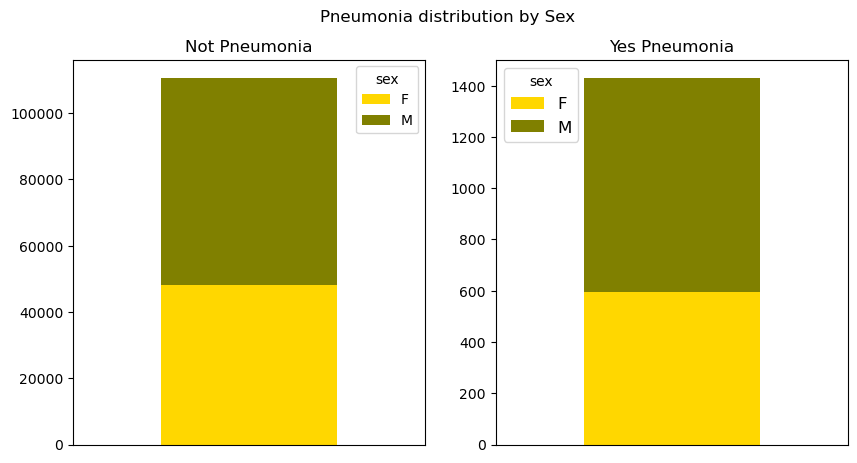

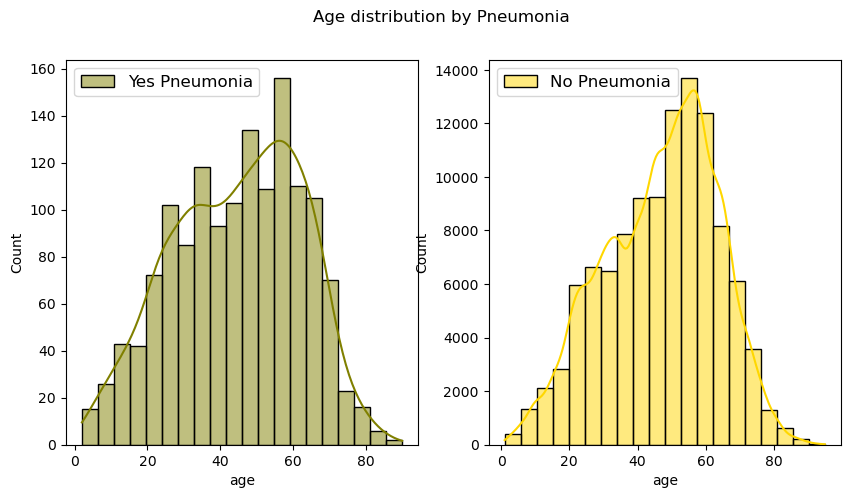

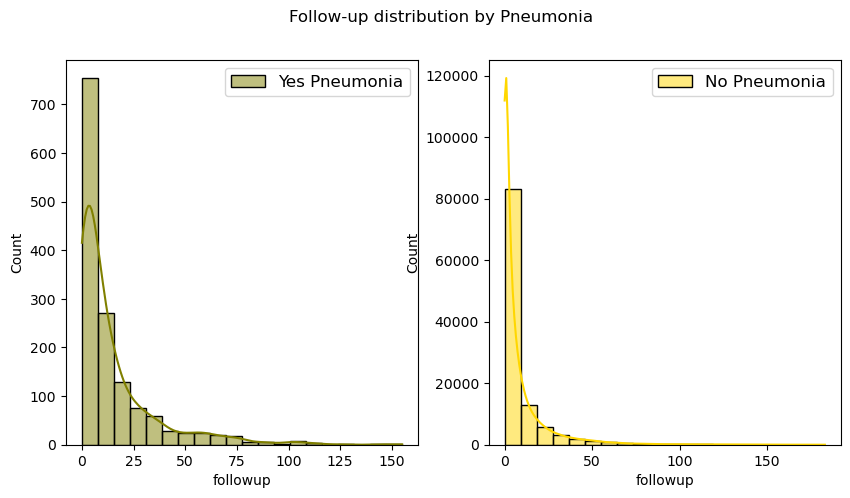

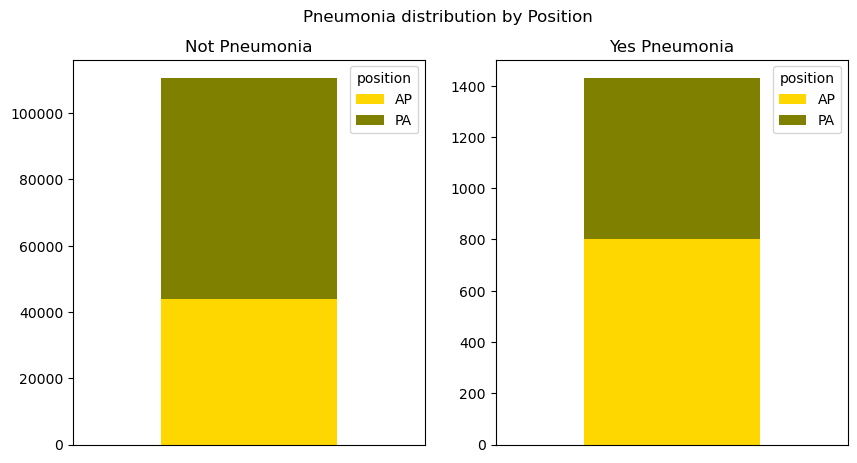

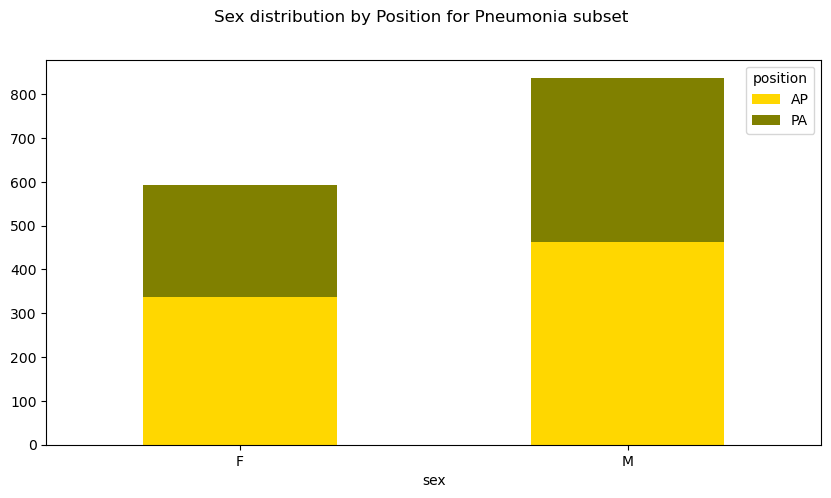

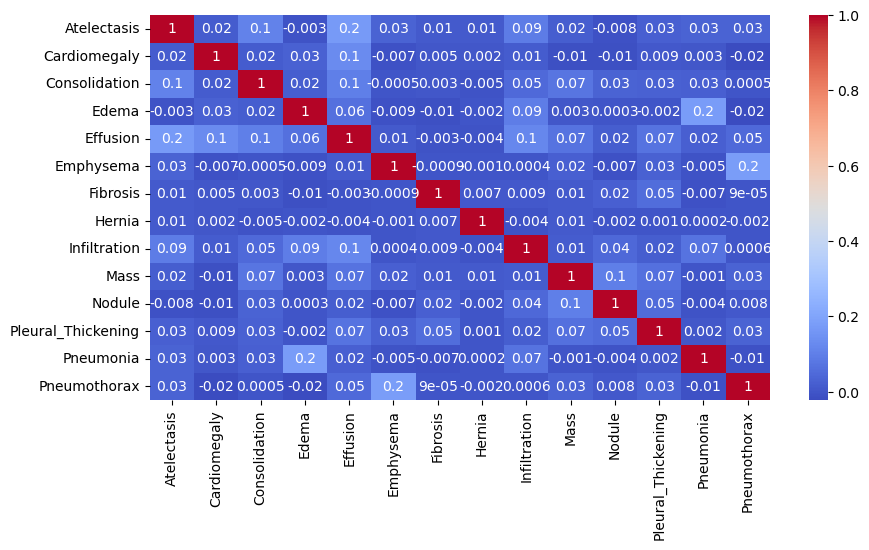

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mask_no = df['Pneumonia'] == 0
mask_yes = df['Pneumonia'] == 1
df[mask_no].groupby('Pneumonia')['sex'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Not Pneumonia', ax=ax[0])
plt.legend(prop={'size': 12}, loc='upper left')
plt.xticks(rotation=0)
plt.suptitle('Pneumonia distribution by Sex')
ax[0].set_xlabel('')
ax[0].set_xticks([])

df[mask_yes].groupby('Pneumonia')['sex'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Yes Pneumonia', ax=ax[1])
plt.legend(prop={'size': 12}, loc='upper left', title = 'sex')
plt.xticks(rotation=0)
ax[1].set_xlabel('')
ax[1].set_xticks([])
plt.show()



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Age distribution by Pneumonia')
sns.histplot(df.loc[df['Pneumonia'] == 1.0, "age"],
            kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0])
sns.histplot(df.loc[df['Pneumonia'] == 0.0, "age"],
            kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1])
ax[0].legend(prop={'size': 12})
ax[1].legend(prop={'size': 12})
plt.show()




fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Follow-up distribution by Pneumonia')
sns.histplot(df.loc[df['Pneumonia'] == 1.0, "followup"],
            kde=True, color="olive", label = 'Yes Pneumonia', bins=20, ax=ax[0])
sns.histplot(df.loc[df['Pneumonia'] == 0.0, "followup"],
            kde=True, color="gold", label = 'No Pneumonia', bins=20, ax=ax[1])
ax[0].legend(prop={'size': 12})
ax[1].legend(prop={'size': 12})
plt.show()



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mask_no = df['Pneumonia'] == 0
mask_yes = df['Pneumonia'] == 1
df[mask_no].groupby('Pneumonia')['position'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Not Pneumonia', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_xticks([])

plt.suptitle('Pneumonia distribution by Position')
df[mask_yes].groupby('Pneumonia')['position'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], title='Yes Pneumonia', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_xlabel('')
plt.show()




fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mask_yes = df['Pneumonia'] == 1
df[mask_yes].groupby('sex')['position'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'olive'], ax=ax)
plt.suptitle('Sex distribution by Position for Pneumonia subset')
plt.xticks(rotation=0)
plt.show()







pathologies = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']

plt.figure(figsize=(10,5))
sns.heatmap(df[pathologies].corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')
plt.show()

### Summary of findings for pneumonia subset: 
- No sex distribution differences for age and followup. Distribution visually is similar to 
- Xray position is inversed in the pneumonia subset: More patients with anteroposterior proyection. 
- There is no significant linear correlation with Spearman test for Pneumonia and other common findings in the chest xray in the correlation plot.

We will make statistical formal tests to check this findings 

## Table one

In [79]:
cat = ['sex', 'position',
    'Atelectasis', 'Cardiomegaly',
    'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
    'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
    'Pneumonia', 'Pneumothorax']

subset = df.drop(['imgindex','labels','id'], axis=1)

from tableone import TableOne

mytable = TableOne(subset, dip_test=True, normal_test=True, tukey_test=True, categorical = cat, pval=False, nonnormal=['followup'], missing=False)

mytable.tableone

Overall
n                                      112104
followup, median [Q1,Q3]       3.0 [0.0,10.0]
age, mean (SD)                    46.9 (16.6)
sex, n (%)                F      48776 (43.5)
                          M      63328 (56.5)
position, n (%)           AP     44805 (40.0)
                          PA     67299 (60.0)
width, mean (SD)               2646.0 (341.2)
height, mean (SD)              2486.4 (401.3)
x, mean (SD)                        0.2 (0.0)
y, mean (SD)                        0.2 (0.0)
Atelectasis, n (%)        0.0   100546 (89.7)
                          1.0    11558 (10.3)
Cardiomegaly, n (%)       0.0   109328 (97.5)
                          1.0      2776 (2.5)
Consolidation, n (%)      0.0   107437 (95.8)
                          1.0      4667 (4.2)
Edema, n (%)              0.0   109802 (97.9)
                          1.0      2302 (2.1)
Effusion, n (%)           0.0    98788 (88.1)
                          1.0    13316 (11.9)
Emphysema, n (%)          0.0   109588 (97.8)
                          1.0      2516 (2.2)
Fibrosis, n (%)           0.0   110418 (98.5)
                          1.0      1686 (1.5)
Hernia, n (%)             0.0   111877 (99.8)
                          1.0       227 (0.2)
Infiltration, n (%)       0.0    92213 (82.3)
                          1.0    19891 (17.7)
Mass, n (%)               0.0   106325 (94.8)
                          1.0      5779 (5.2)
No Finding, n (%)         0.0    51751 (46.2)
                          1.0    60353 (53.8)
Nodule, n (%)             0.0   105773 (94.4)
                          1.0      6331 (5.6)
Pleural_Thickening, n (%) 0.0   108720 (97.0)
                          1.0      3384 (3.0)
Pneumonia, n (%)          0.0   110674 (98.7)
                          1.0      1430 (1.3)
Pneumothorax, n (%)       0.0   106803 (95.3)
                          1.0      5301 (4.7)

## Table two

In [86]:
cat = ['sex', 'position',
    'Atelectasis', 'Cardiomegaly',
    'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
    'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
    'Pneumonia', 'Pneumothorax']

subset = df.drop(['imgindex','labels','id'], axis=1)
subset['Pneumonia'] = np.where(subset['Pneumonia'] == 1, 'Yes', 'No')

from tableone import TableOne

mytable = TableOne(subset, dip_test=True, normal_test=True, tukey_test=True, categorical = cat, pval=True, nonnormal=['followup'], missing=False, groupby='Pneumonia', htest_name=True, label_suffix=True, overall=False)

mytable.tableone

Grouped by Pneumonia                          \
                                                No             Yes P-Value   
n                                           110674            1430           
followup, median [Q1,Q3]             3.0 [0.0,9.0]  7.0 [2.0,18.0]  <0.001   
age, mean (SD)                         46.9 (16.6)     44.7 (17.6)  <0.001   
sex, n (%)                F           48183 (43.5)      593 (41.5)   0.124   
                          M           62491 (56.5)      837 (58.5)           
position, n (%)           AP          44005 (39.8)      800 (55.9)  <0.001   
                          PA          66669 (60.2)      630 (44.1)           
width, mean (SD)                    2645.7 (341.4)  2668.4 (329.1)   0.010   
height, mean (SD)                   2487.0 (401.4)  2442.1 (388.5)  <0.001   
x, mean (SD)                             0.2 (0.0)       0.2 (0.0)   0.127   
y, mean (SD)                             0.2 (0.0)       0.2 (0.0)   0.127   
Atelectasis, n (%)        0.0         99378 (89.8)     1168 (81.7)  <0.001   
                          1.0         11296 (10.2)      262 (18.3)           
Cardiomegaly, n (%)       0.0        107939 (97.5)     1389 (97.1)   0.383   
                          1.0           2735 (2.5)        41 (2.9)           
Consolidation, n (%)      0.0        106130 (95.9)     1307 (91.4)  <0.001   
                          1.0           4544 (4.1)       123 (8.6)           
Edema, n (%)              0.0        108712 (98.2)     1090 (76.2)  <0.001   
                          1.0           1962 (1.8)      340 (23.8)           
Effusion, n (%)           0.0         97626 (88.2)     1162 (81.3)  <0.001   
                          1.0         13048 (11.8)      268 (18.7)           
Emphysema, n (%)          0.0        108181 (97.7)     1407 (98.4)   0.123   
                          1.0           2493 (2.3)        23 (1.6)           
Fibrosis, n (%)           0.0        108999 (98.5)     1419 (99.2)   0.029   
                          1.0           1675 (1.5)        11 (0.8)           
Hernia, n (%)             0.0        110450 (99.8)     1427 (99.8)   0.768   
                          1.0            224 (0.2)         3 (0.2)           
Infiltration, n (%)       0.0         91388 (82.6)      825 (57.7)  <0.001   
                          1.0         19286 (17.4)      605 (42.3)           
Mass, n (%)               0.0        104966 (94.8)     1359 (95.0)   0.790   
                          1.0           5708 (5.2)        71 (5.0)           
No Finding, n (%)         0.0         50321 (45.5)    1430 (100.0)  <0.001   
                          1.0         60353 (54.5)                           
Nodule, n (%)             0.0        104413 (94.3)     1360 (95.1)   0.237   
                          1.0           6261 (5.7)        70 (4.9)           
Pleural_Thickening, n (%) 0.0        107338 (97.0)     1382 (96.6)   0.500   
                          1.0           3336 (3.0)        48 (3.4)           
Pneumonia, n (%)          No        110674 (100.0)                  <0.001   
                          Yes                         1430 (100.0)           
Pneumothorax, n (%)       0.0        105414 (95.2)     1389 (97.1)   0.001   
                          1.0           5260 (4.8)        41 (2.9)           

                                                  
                                            Test  
n                                                 
followup, median [Q1,Q3]          Kruskal-Wallis  
age, mean (SD)                 Two Sample T-test  
sex, n (%)                F          Chi-squared  
                          M                       
position, n (%)           AP         Chi-squared  
                          PA                      
width, mean (SD)               Two Sample T-test  
height, mean (SD)              Two Sample T-test  
x, mean (SD)                   Two Sample T-test  
y, mean (SD)                   Two Sample T-test  
Atelectasis,

#### Main findings for Pneumonia:
- It is frequently and positive associated with Atelectasis, Consolidation, Edema, Effusion and Infiltration, with P value < 0.05 for Chi-square test. This makes sense with clinical and physiopatological explanations.
- It is inversily associated with the presence of Pneumothorax and Fibrosis (Chi square < 0.05)
- Pneumonia patients are usually more critically ill and chest xray is more frequently taken on anteroposterior position (Chi square < 0.05).
- Patients with Pneumonia are younger with T-test < 0.05. That's unexpected, usually older people get pneumonia. 

### Some thougths about labels:

It is difficult to think about Pneumonia without thinking about consolidation or infiltration. Pneumonia is a clinical diagnosis (the mix of bacteriological and viral panel, xrays, CT scan, lab analysis and clinical findings on physical examination), not just a radiological one, so makes sense it isn't frequently annotated in the radiology reports. 

Usually radiologist reports inform findings about consolidation or infiltration, and the attendant physician integrates that information with other tests for reaching Pneumonia diagnosis. 

It is usual to label in the clinical practice pneumonia as 'typical pneumonia' when has consolidation in xray, and 'atypical pneumonia' when it has infiltration. Although not highly correlated, usually typical vs atypical pneumonia are associated with different ethiology. 

### Limitations of the dataset:
- Labels should have been done not only with radiological reports but with final clinical diagnosis. Probably a lot of consolidation and infiltrations are associated with low lung infection (pneumonia!).
- NLP accuraccy could lead to errors in labeling. 
- Dataset is highly unbalanced for pneumonia (1% of the dataset).
- We don't have information about pneumonia clinical presentation, but if patients with Pneumonia are more critically ill, they will have more medical devices plugged, with orotraqueal intubation and mechanical ventilation assistance. Probably a deep learning CNN will easily learn that wires and medical devices are associated with this condition. It would be 'ideal' to segmentate images and keep only lung information. 

## Pixel assesement

Histogram examples with the correspondant chest xray

In [101]:
## Load 'sample_labels.csv' data for pixel level assessments
sample = pd.read_csv('./data/sample_labels.csv',header=0,names=columns[:-1])

all_labels = np.unique(list(chain(*sample['labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample[c_label] = sample['labels'].map(lambda finding: 1.0 if c_label in finding else 0)

sample['Pneumonia'].value_counts()

0.0    5544
1.0      62
Name: Pneumonia, dtype: int64

### Pneumonia vs No Pneumonia histogram comparisons

Remember that 'No Pneumonia' is not a normal x-ray. Pneumonia label is frequently concomitant with infiltration, edema and consolidation. 

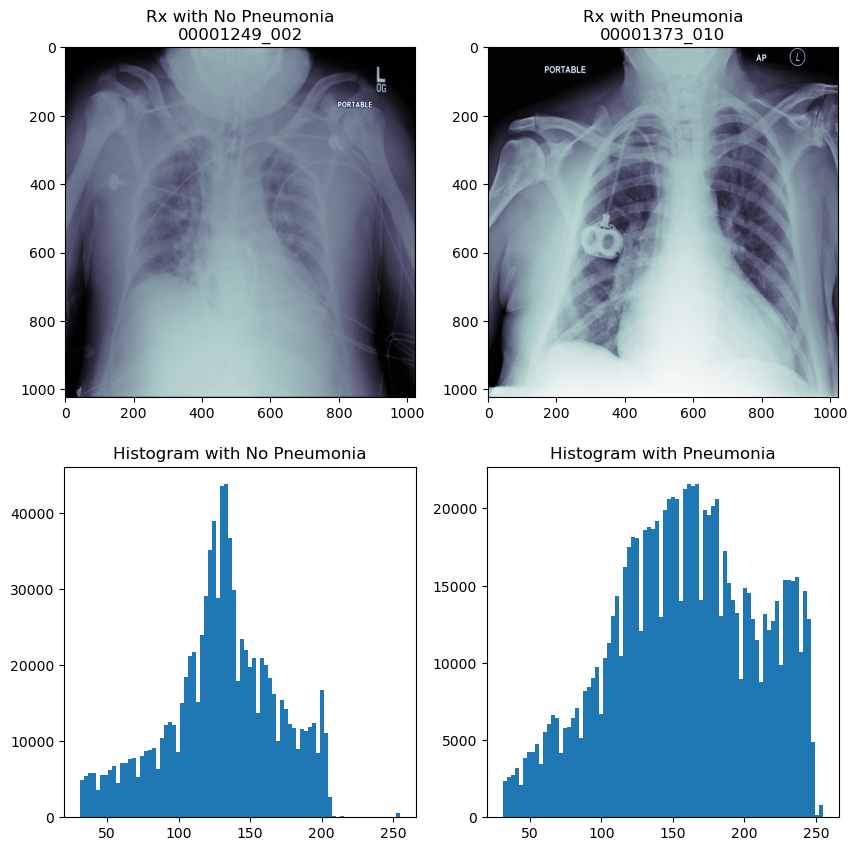

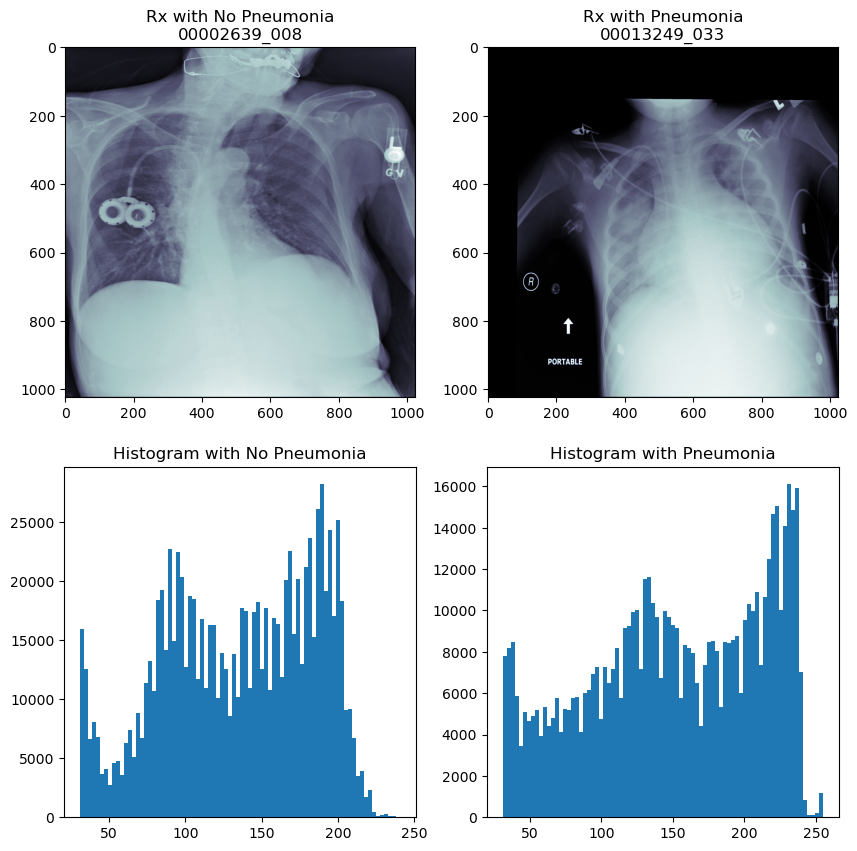

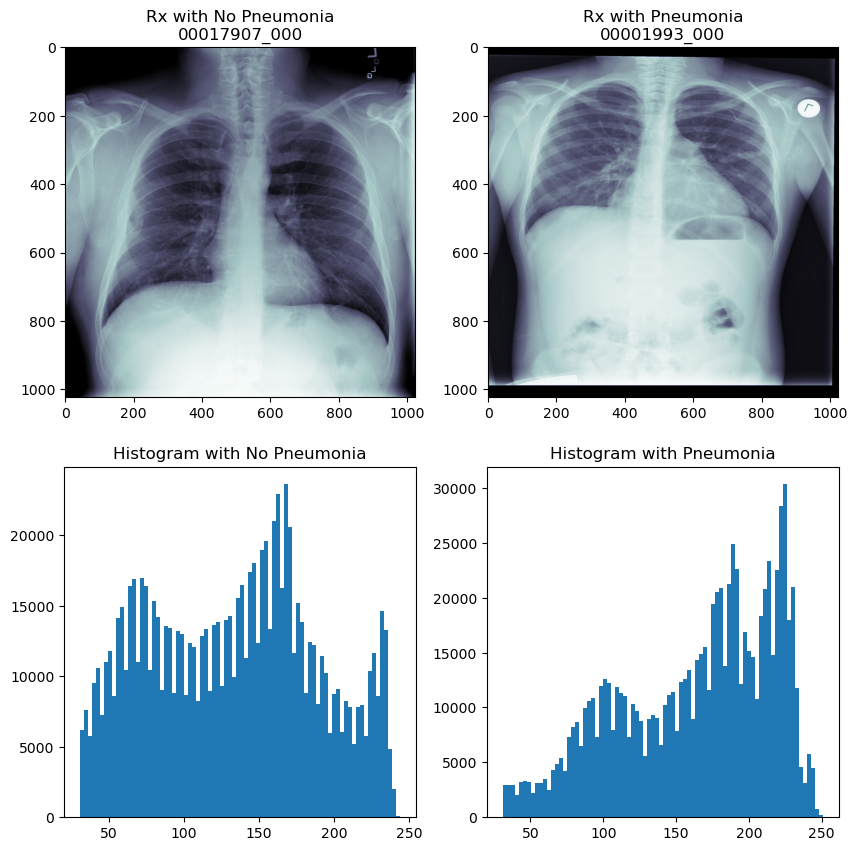

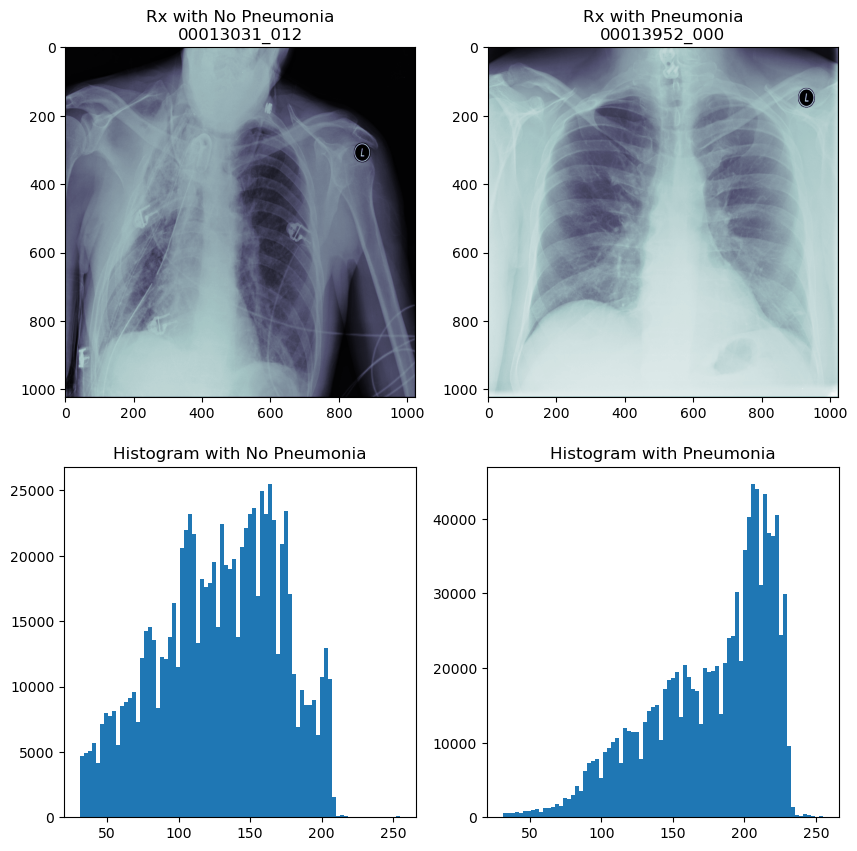

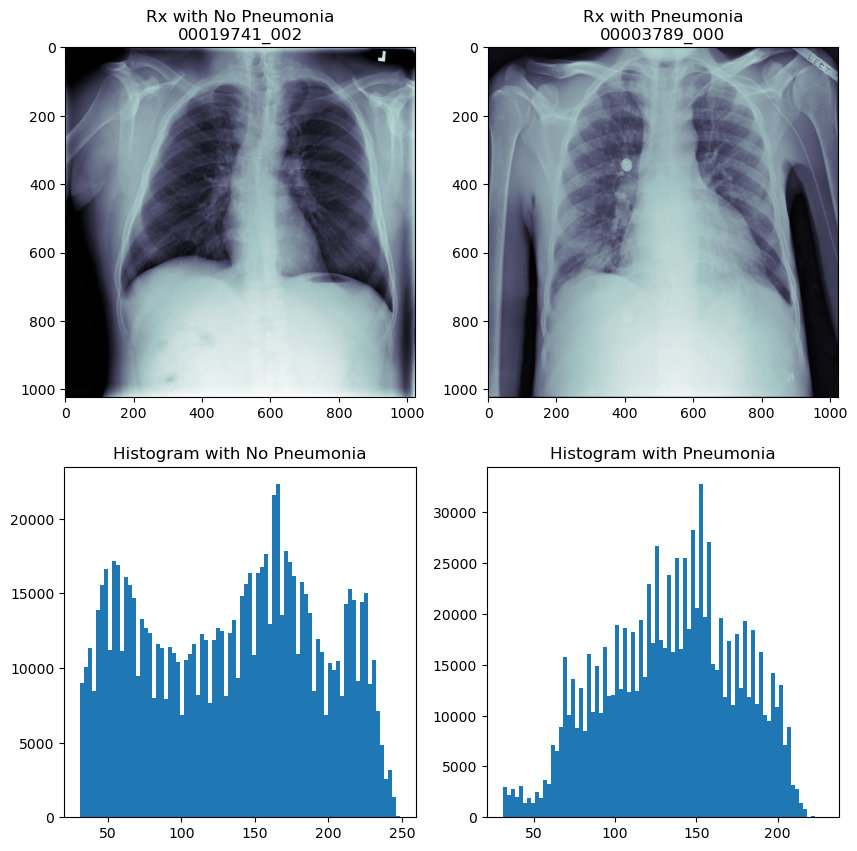

In [ ]:
path = './bigdata/images/all/'
background_limit = 30
binary = [0.0 , 1.0]
n_images = 5

def print_image_x2(df, path = path, background_limit = background_limit, n_images = n_images):
    binary = [0.0 , 1]
    for n in range(n_images):
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        for i in binary:
            mask_bin = df['Pneumonia'] == i
            img_name = df.loc[mask_bin,:].sample(1)['imgindex'].tolist()[0]
            img_file = path + img_name
            img = io.imread(img_file)

            if i == 1.0: title = 'Pneumonia' 
            else: title = 'No Pneumonia'
            
            ax[0,int(i)].imshow(img, cmap=plt.cm.bone)
            name = img_name.split('/')[-1].split('.')[0]
            ax[0,int(i)].set_title('Rx with {}\n{}'.format(title, name))
            ax[1,int(i)].hist(img[img>background_limit].flatten(), bins=80)
            ax[1,int(i)].set_title('Histogram with {}'.format(title))
        plt.show()


print_image_x2(sample)

In [ ]:
sample['No Finding'].value_counts()

1.0    3044
0.0    2562
Name: No Finding, dtype: int64

### Pneumonia vs Normal XRay histogram comparison

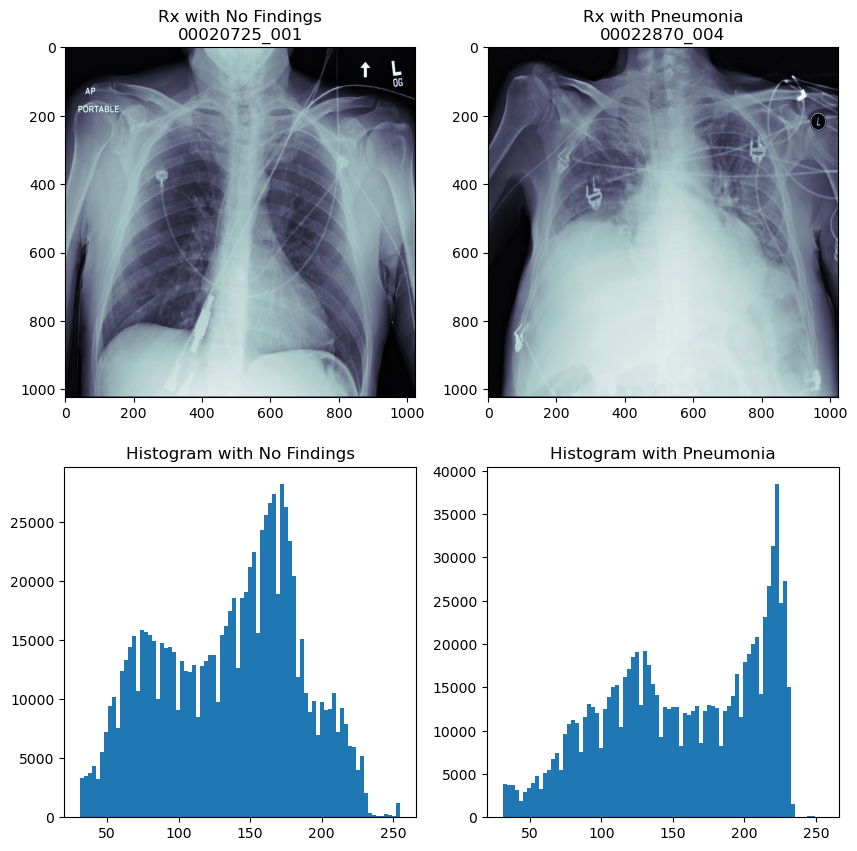

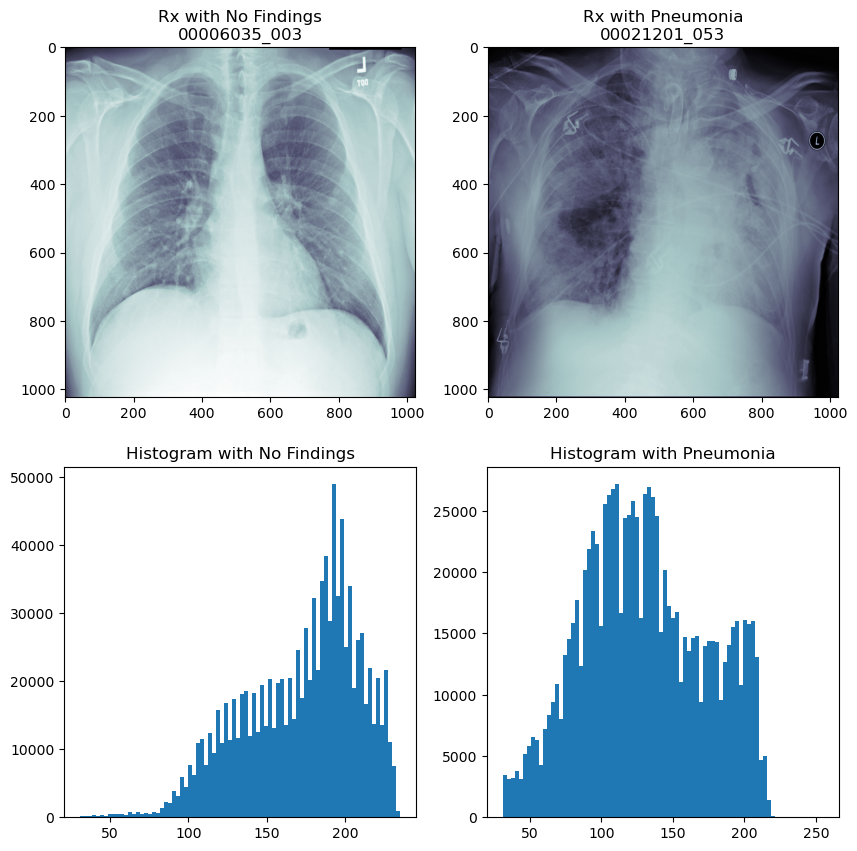

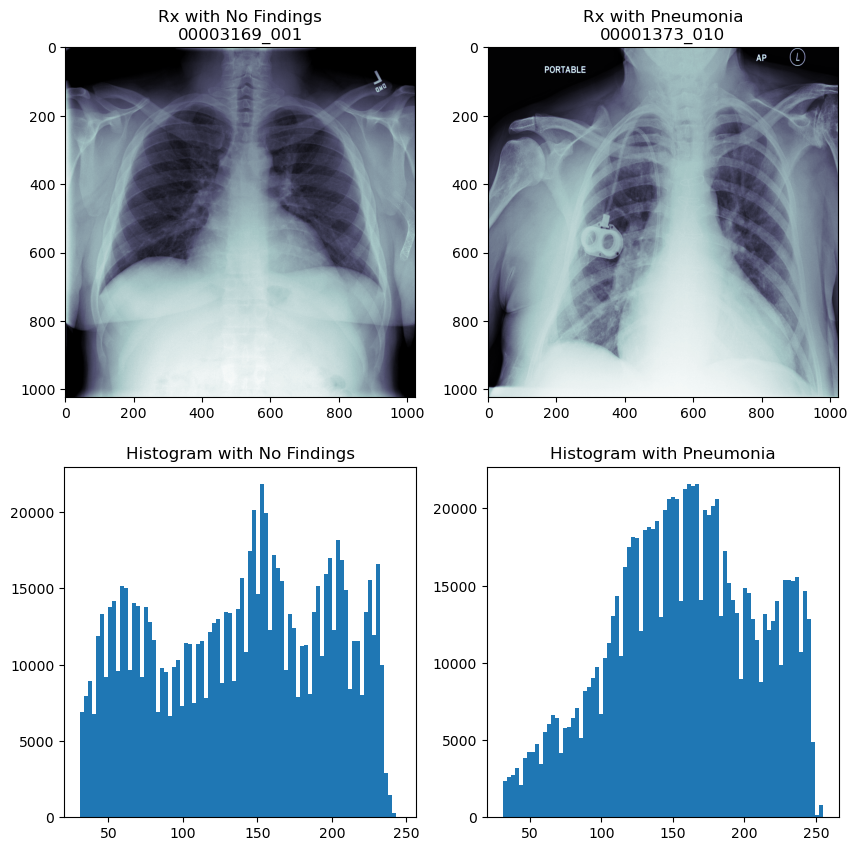

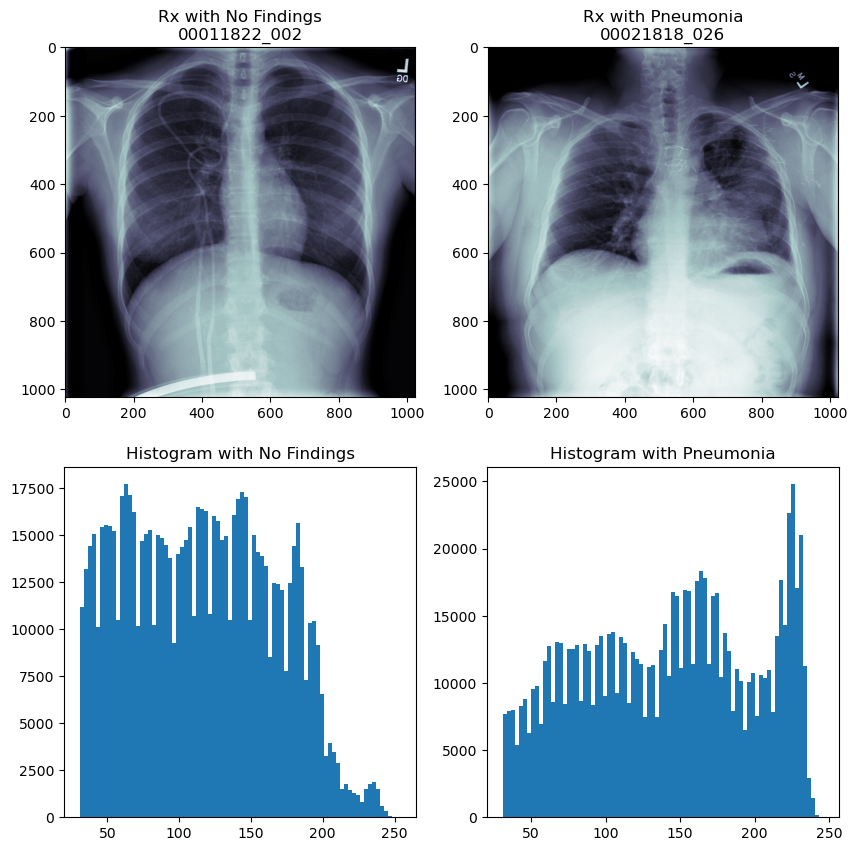

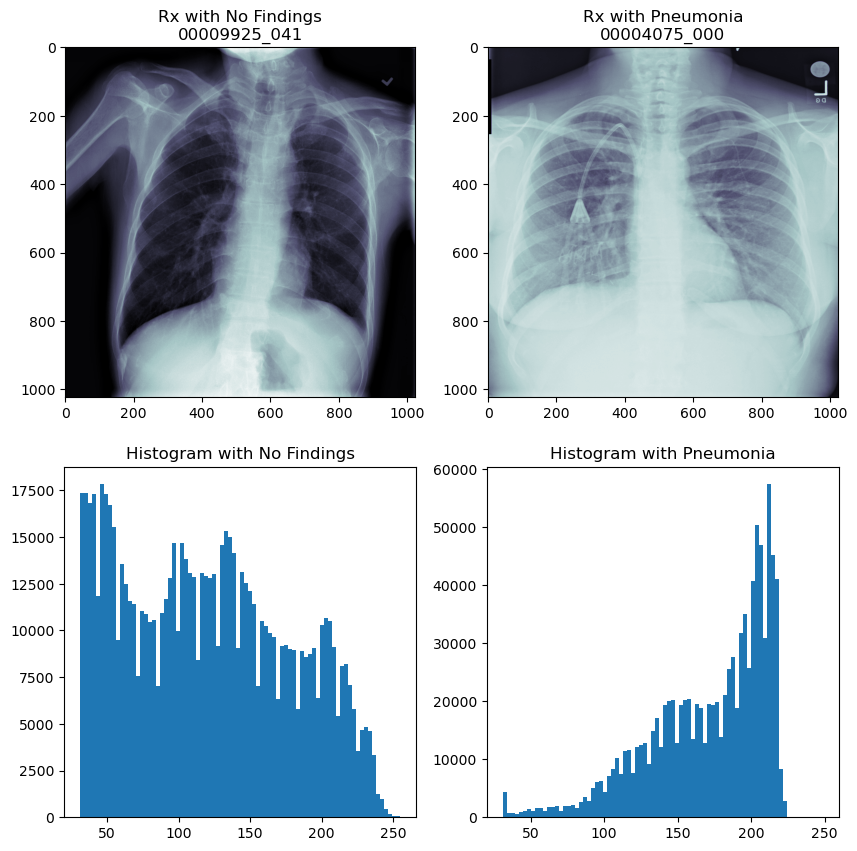

In [ ]:
path = './bigdata/images/all/'
background_limit = 30
binary = [0.0 , 1.0]
n_images = 5

def print_image_x2(df, path = path, background_limit = background_limit, n_images = n_images):
    binary = [0.0 , 1]
    for n in range(n_images):
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        mask_normal = df['No Finding'] == 1
        for i in binary:
            mask_bin = df['Pneumonia'] == i
            if i == 0.0:
                img_name = df.loc[mask_bin & mask_normal,:].sample(1)['imgindex'].tolist()[0]
            else:
                img_name = df.loc[mask_bin,:].sample(1)['imgindex'].tolist()[0]
            img_file = path + img_name
            img = io.imread(img_file)

            if i == 1.0: title = 'Pneumonia' 
            else: title = 'No Findings'
            
            ax[0,int(i)].imshow(img, cmap=plt.cm.bone)
            name = img_name.split('/')[-1].split('.')[0]
            ax[0,int(i)].set_title('Rx with {}\n{}'.format(title, name))
            ax[1,int(i)].hist(img[img>background_limit].flatten(), bins=80)
            ax[1,int(i)].set_title('Histogram with {}'.format(title))
        plt.show()


print_image_x2(sample)

## Global histogram for each label for all sample dataset
https://discuss.pytorch.org/t/plot-a-histogram-for-multiple-images-full-dataset/67600/7

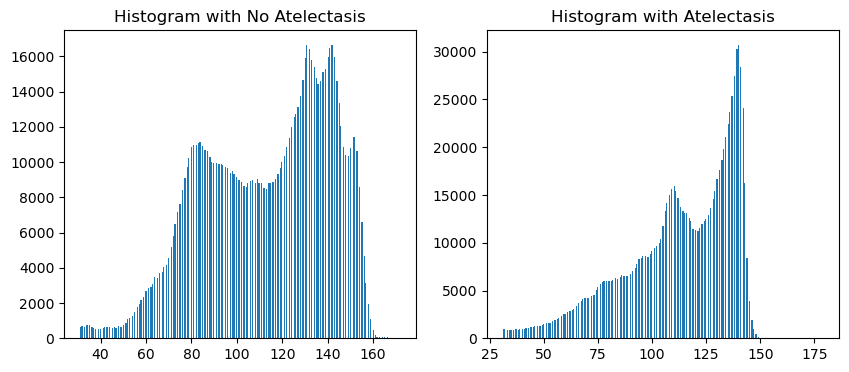

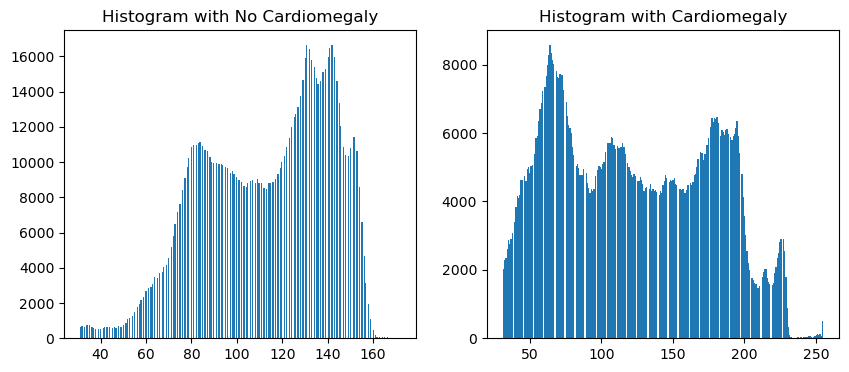

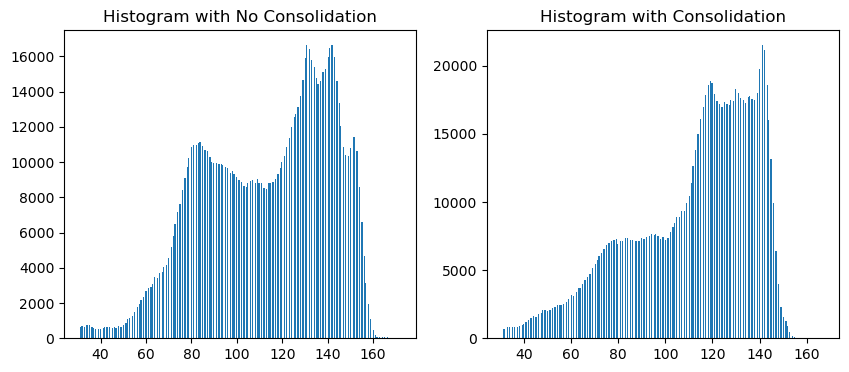

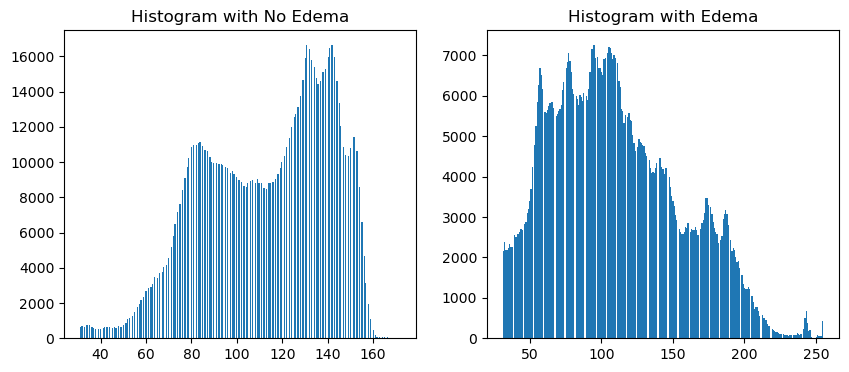

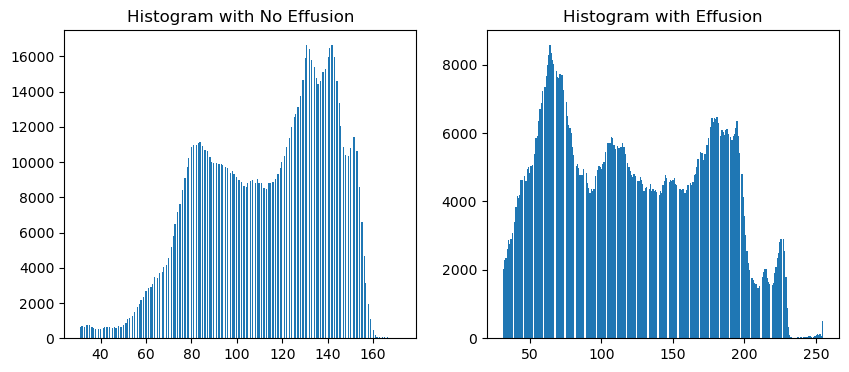

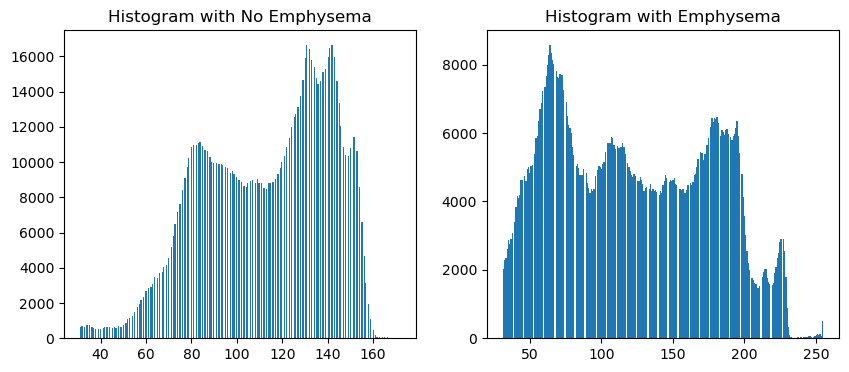

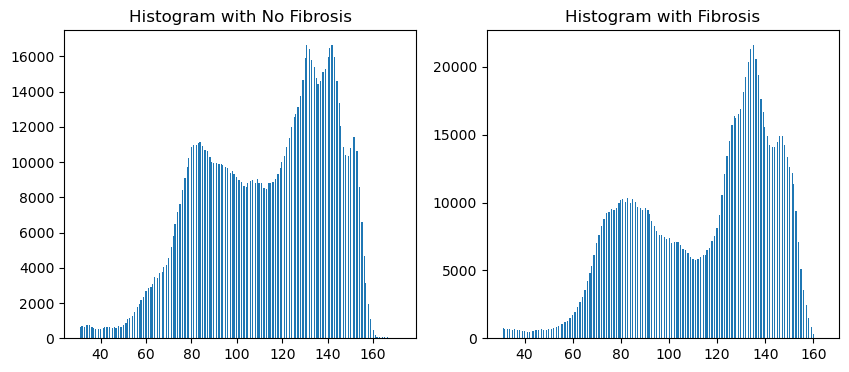

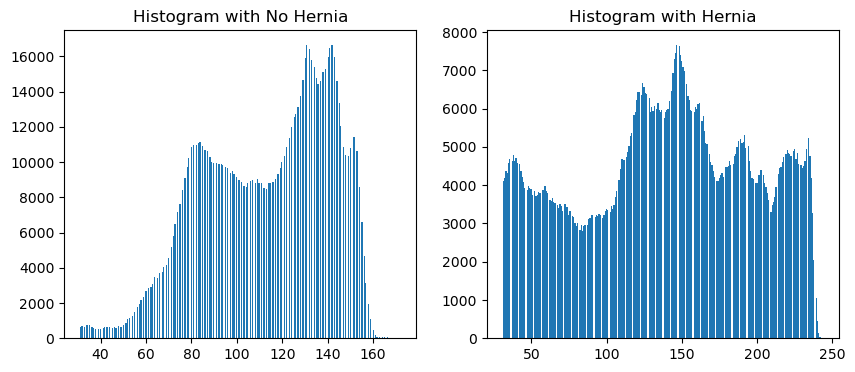

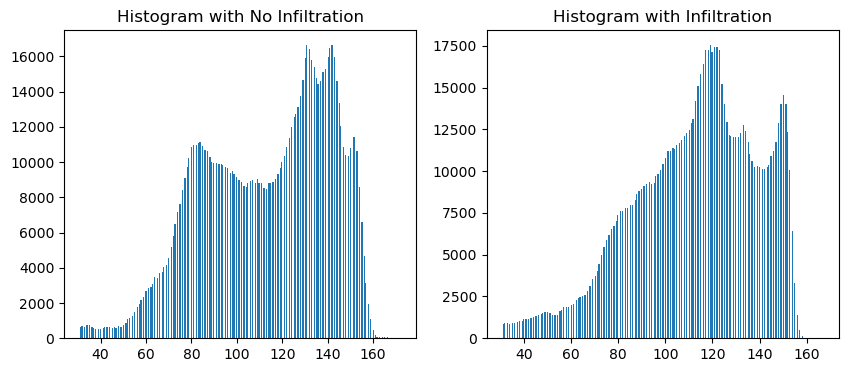

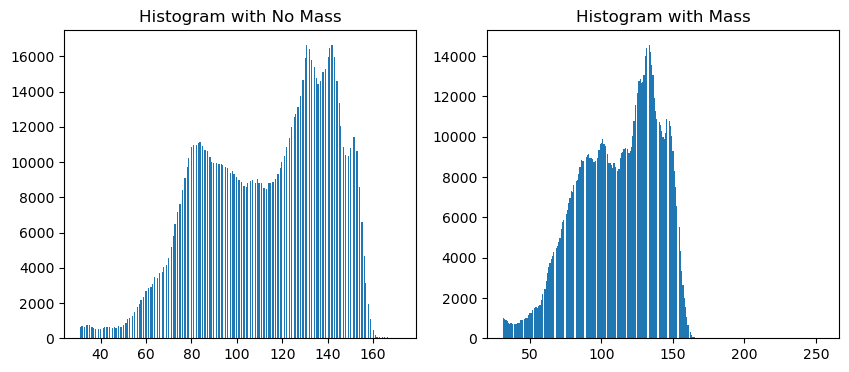

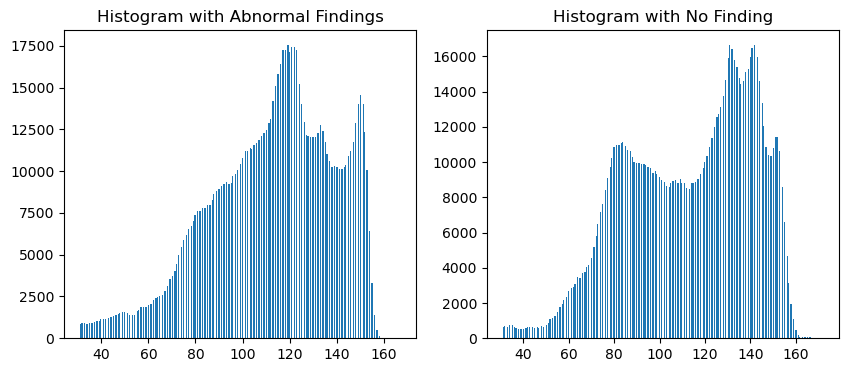

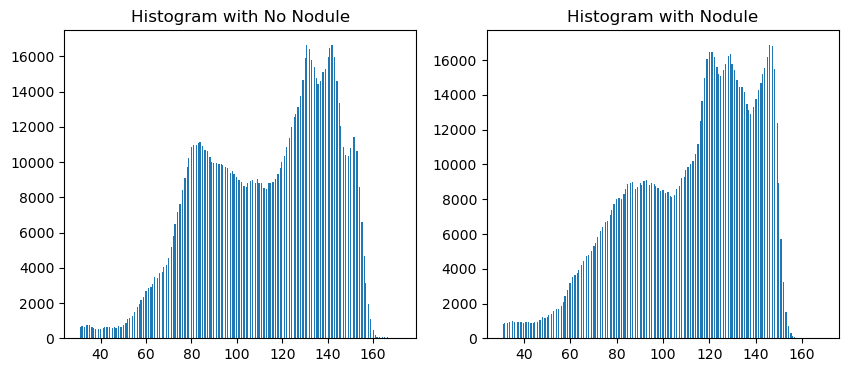

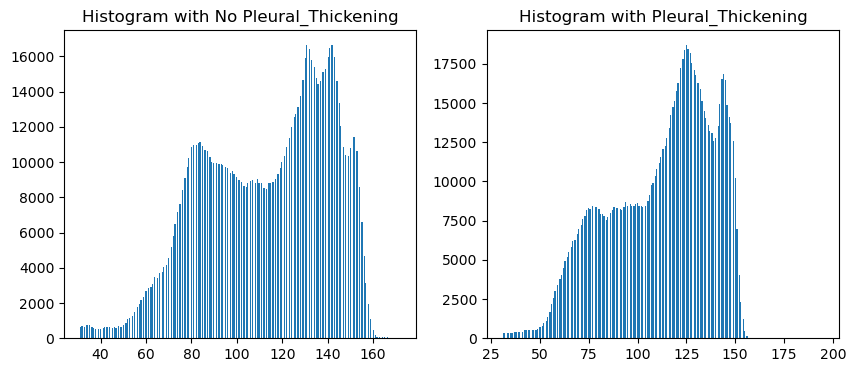

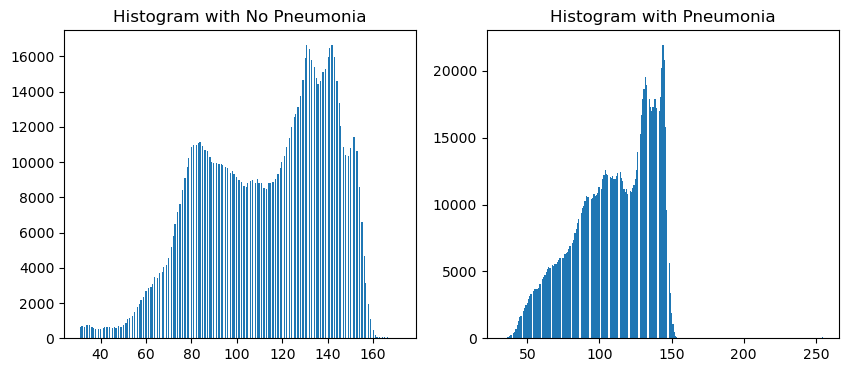

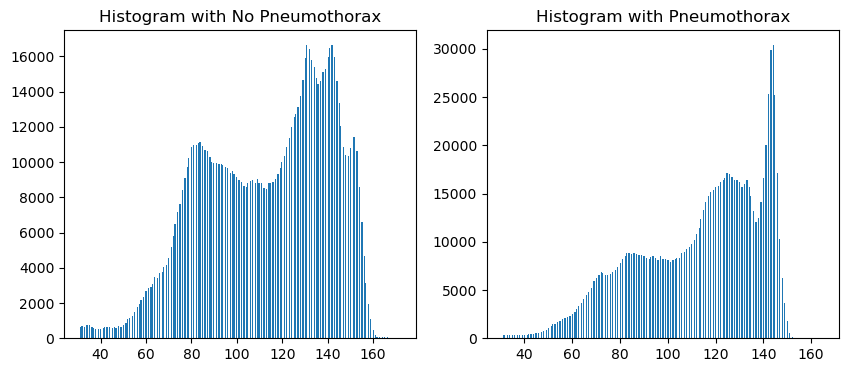

In [ ]:
path = './bigdata/images/all/'
nb_bins = 256
count_bw = np.zeros(nb_bins)
n_images = sample.shape[0]
background_limit = 30
column_to_assess = 'No Finding'
seed = 42

def hist_all(column = 'Pneumonia', path = path, nb_bins = nb_bins, count_bw = count_bw, n_images = n_images):
    if type(column) != str:
        for feature in column:
            fig, ax = plt.subplots(1,2, figsize=(10,4))
            subsample = sample.loc[sample['Pneumonia'] == 0,:]
            for i in [0.0,1.0]:
                mask_bin = sample[feature] == i
                for file in sample.loc[mask_bin,'imgindex'].iloc[0:n_images]:
                    img_file = path + file
                    img = io.imread(img_file)
                    hist_bw = np.histogram(img, bins=nb_bins, range=[0, 255])
                    count_bw += hist_bw[0]
                bins = hist_bw[1]
                if i == 1.0: title = feature
                elif i == 0.0 and feature == 'No Finding': title = 'Abnormal Findings'
                else: title = 'No ' + feature
                ax[int(i)].hist(img[img>background_limit].flatten(), bins=255)
                ax[int(i)].set_title('Histogram with {}'.format(title))
            plt.show()
    else:
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        for i in [0.0,1.0]:
            mask_bin = sample[column] == i
            for file in sample.loc[mask_bin,'imgindex'].iloc[0:n_images]:
                img_file = path + file
                img = io.imread(img_file)
                hist_bw = np.histogram(img, bins=nb_bins, range=[0, 255])
                count_bw += hist_bw[0]
            bins = hist_bw[1]
            if i == 1.0: title = column
            elif i == 0.0 and column == 'No Finding': title = 'Abnormal Findings'
            else: title = 'No ' + column
            ax[int(i)].hist(img[img>background_limit].flatten(), bins=255)
            ax[int(i)].set_title('Histogram with {}'.format(title))
        plt.show()

columns_of_interest = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']

hist_all(columns_of_interest)

### Final thoughts for pixel assesment:
- Consolidation and infiltration shows a 'similar' peak in the histogram. 
- I would expected a similar peak finding for pneumonia patients, but it is not happening in this dataset.
- Normal X-ray vs. Non-normal X-ray histograms are different.
- There are some outliers for some pathologies, with high intensity pixels > 250. It is clearly visible in Pneumonia and Mass. Are those medical devices or prosthetic material? 